<a href="https://colab.research.google.com/github/devbabbar7/Udacity-Introduction-to-Tensorflow-for-Deep-Learning/blob/main/l08c05_forecasting_with_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting with machine learning

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

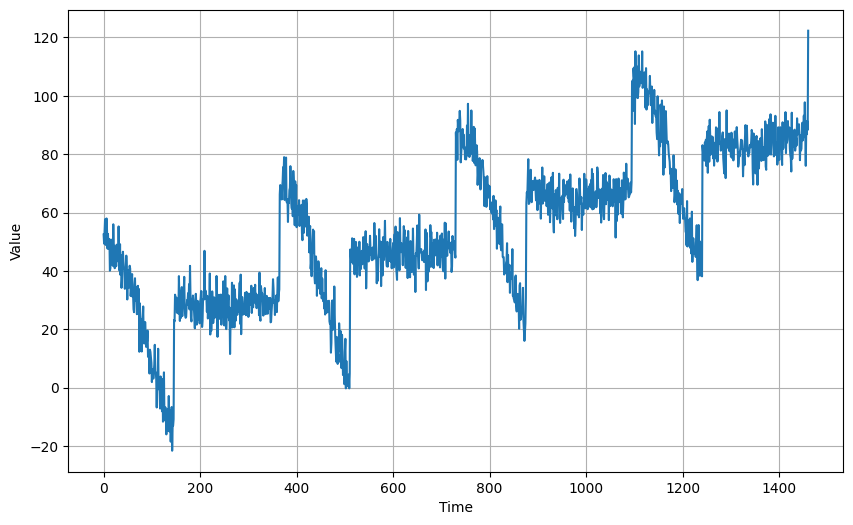

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [4]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 3s 48ms/step - loss: 442.8915 - mae: 443.3913 - val_loss: 1403.3226 - val_mae: 1403.8226
Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 570.2394 - mae: 570.7394 - val_loss: 519.8734 - val_mae: 520.3734
Epoch 3/100
31/31 [==============================] - 1s 15ms/step - loss: 342.8357 - mae: 343.3340 - val_loss: 1476.1031 - val_mae: 1476.6031
Epoch 4/100
31/31 [==============================] - 1s 14ms/step - loss: 355.0867 - mae: 355.5857 - val_loss: 733.6440 - val_mae: 734.1440
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 725.6213 - mae: 726.1213 - val_loss: 254.9603 - val_mae: 255.4603
Epoch 6/100
31/31 [==============================] - 1s 35ms/step - loss: 918.9306 - mae: 919.4298 - val_loss: 2456.3564 - val_mae: 2456.8564
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 833.8132 - mae: 834.3132 - val_loss: 295.9031 - val_mae: 296.4031
Epoch 8/100
31

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 131.9357 - mae: 132.4353 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 116.3674 - mae: 116.8667 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 98.0265 - mae: 98.5263 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 78.2734 - mae: 78.7722 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 57.0198 - mae: 57.5198 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 34.1807 - mae: 34.6799 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 12.6118 - mae: 13.1018 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 7.6900 - mae: 8.1748 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 7.5642 - mae: 8.0487 

(1e-06, 0.001, 0.0, 20.0)

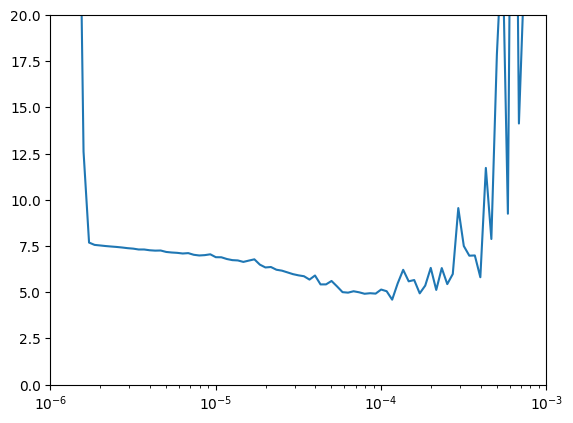

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 11ms/step - loss: 404.3705 - mae: 404.8704 - val_loss: 482.1242 - val_mae: 482.6242
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 476.7535 - mae: 477.2535 - val_loss: 477.9661 - val_mae: 478.4661
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 872.9594 - mae: 873.4587 - val_loss: 1289.0421 - val_mae: 1289.5421
Epoch 4/500
31/31 [==============================] - 0s 7ms/step - loss: 879.9520 - mae: 880.4520 - val_loss: 710.0375 - val_mae: 710.5375
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 942.9229 - mae: 943.4227 - val_loss: 1263.5049 - val_mae: 1264.0049
Epoch 6/500
31/31 [==============================] - 0s 8ms/step - loss: 775.7634 - mae: 776.2628 - val_loss: 2099.7969 - val_mae: 2100.2969
Epoch 7/500
31/31 [==============================] - 0s 8ms/step - loss: 767.1672 - mae: 767.6672 - val_loss: 1339.9489 - val_mae: 1340.4489
Epoch 8/500
31/31 

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 13ms/step


In [12]:
lin_forecast.shape

(461,)

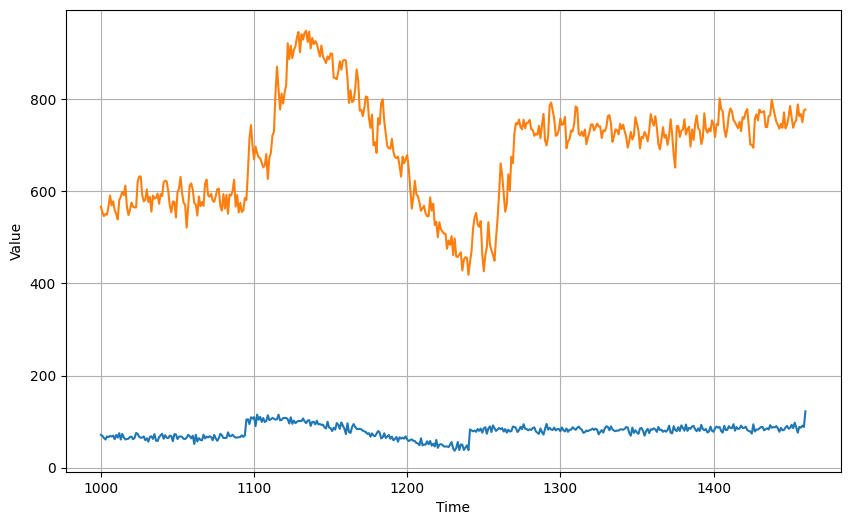

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [14]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

610.35284

### Dense Model Forecasting

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 8.2646 - mae: 8.7530 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 7.8986 - mae: 8.3875 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 7.5259 - mae: 8.0106 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 7.2334 - mae: 7.7125 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 7.0306 - mae: 7.5124 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 6.9048 - mae: 7.3912 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 6.8177 - mae: 7.3030 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 6.7658 - mae: 7.2455 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 6.7375 - mae: 7.2162 - lr: 2.5119e-07
E

(1e-07, 0.005, 0.0, 30.0)

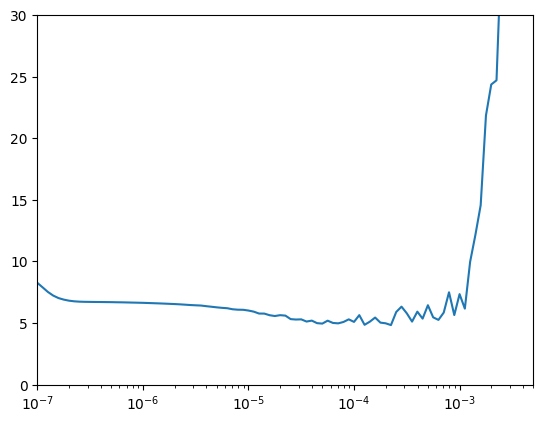

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 12ms/step - loss: 51.5900 - mae: 52.0887 - val_loss: 77.2079 - val_mae: 77.7079
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 51.9191 - mae: 52.4174 - val_loss: 74.3418 - val_mae: 74.8418
Epoch 3/500
31/31 [==============================] - 0s 8ms/step - loss: 37.2663 - mae: 37.7647 - val_loss: 71.5361 - val_mae: 72.0361
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 35.1337 - mae: 35.6332 - val_loss: 68.7499 - val_mae: 69.2499
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 40.0499 - mae: 40.5490 - val_loss: 66.0134 - val_mae: 66.5134
Epoch 6/500
31/31 [==============================] - 1s 16ms/step - loss: 30.1108 - mae: 30.6103 - val_loss: 63.3662 - val_mae: 63.8662
Epoch 7/500
31/31 [==============================] - 1s 11ms/step - loss: 27.9212 - mae: 28.4188 - val_loss: 60.8173 - val_mae: 61.3173
Epoch 8/500
31/31 [==============================] -

In [18]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 8ms/step


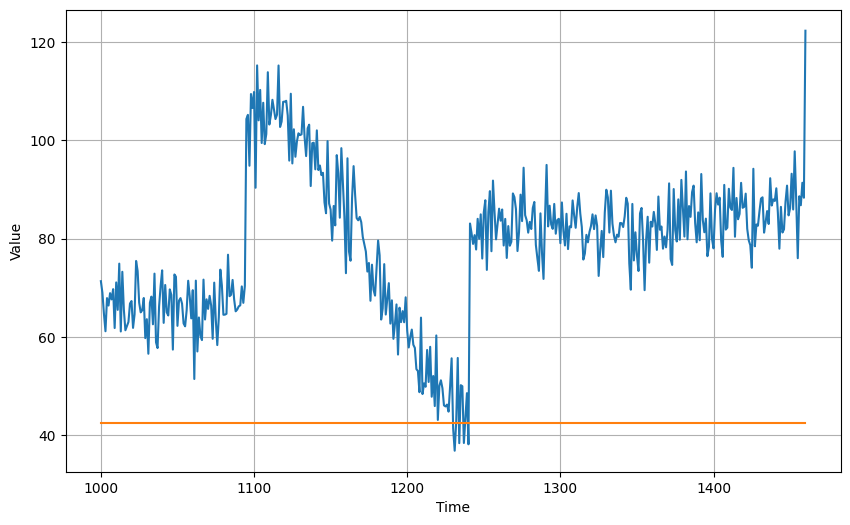

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

35.957733